<a href="https://colab.research.google.com/github/Lexi-Zhou/stats201-project-zzz/blob/main/Code/W2_2_Gender_label.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. Categorize gender based on student comments

Process gender labels based on 02_RMP_cleaned.csv

## 2.1 Data loading

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Loaded: /content/drive/MyDrive/Colab Notebooks/stats201_final_project/Week_2/RMP_cleaned.csv
Shape: (19685, 8)
['professor_name', 'school_name', 'department_name_clean', 'stu_tags', 'student_star', 'comments', 'rating_group', 'tag_list']


In [ ]:
# Load dataset

in_path = "/content/drive/MyDrive/Colab Notebooks/stats201_final_project/Week_2/02_RMP_cleaned.csv"
df = pd.read_csv(in_path)

print("Loaded:", in_path)
print("Shape:", df.shape)
print(df.columns.tolist())


Loaded: /content/drive/MyDrive/Colab Notebooks/stats201_final_project/Week_2/RMP_cleaned.csv
Shape: (19685, 8)
['professor_name', 'school_name', 'department_name_clean', 'stu_tags', 'student_star', 'comments', 'rating_group', 'tag_list']


## 2.2 Gender classification lexicon

Notes:
- Exclude ambiguous terms like "miss" (can mean "to miss a class").
- Keep tokens that are strong, common gender references in English writing.


In [ ]:
import re

female_terms = {
    "she", "her", "hers", "herself",
    "ms", "mrs",
    "woman", "female",
    "she\'s"
}

male_terms = {
    "he", "him", "his", "himself",
    "mr", "man",
    "male", "guy",
    "he\'s"
}



## 2.3 Comment level gender labels

In [ ]:
def detect_gender_from_text(text: str) -> str:
    """
    Detect gender reference from a single comment text using a conservative lexicon.

    Returns one of:
    - "female": contains female terms only
    - "male": contains male terms only
    - "conflict": contains both female and male terms
    - "unknown": contains neither
    """
    if pd.isna(text):
        return "unknown"

    s = str(text).lower()

    # Extract word tokens (letters/numbers/underscore). This avoids partial matches.
    tokens = set(re.findall(r"\b\w+\b", s))

    has_female = len(tokens & female_terms) > 0
    has_male = len(tokens & male_terms) > 0

    if has_female and not has_male:
        return "female"
    if has_male and not has_female:
        return "male"
    if has_female and has_male:
        return "conflict"
    return "unknown"


In [ ]:
import re

# Create comment-level gender signal
df["comment_gender_signal"] = df["comments"].apply(detect_gender_from_text)

# Summary: count each category at comment level
comment_gender_summary = df["comment_gender_signal"].value_counts(dropna=False)
print("Comment-level gender signal summary:")
print(comment_gender_summary)


Comment-level gender signal summary:
comment_gender_signal
male        7971
female      7767
unknown     3859
conflict      88
Name: count, dtype: int64


In [ ]:
# Flag and inspect conflict comments (optional but recommended)

conflict_comments = df[df["comment_gender_signal"] == "conflict"][["professor_name", "school_name", "department_name_clean", "comments"]]

print("Number of conflict comments:", len(conflict_comments))
conflict_comments

df.to_csv(
    "/content/drive/MyDrive/Colab Notebooks/stats201_final_project/Week_2/03_RMP_comment_with_gender_labels.csv",
    index=False
)

conflict_comments.to_csv(
    "/content/drive/MyDrive/Colab Notebooks/stats201_final_project/Week_2/04_Conflict_comments.csv",
    index=False
)

Number of conflict comments: 88


### 2.3.1 After manual recoding merge

In [ ]:
import pandas as pd

# Load the manually recoded conflict comments file

recode_path = "/content/drive/MyDrive/Colab Notebooks/stats201_final_project/Week_2/05_Conflict_comments_manual_recoded.csv"
recode = pd.read_csv(recode_path)


In [ ]:
print(recode.columns.tolist())


['professor_name', 'school_name', 'department_name_clean', 'comments', 'manual_check']


In [ ]:
# Standardize the manual coding column to lowercase (for consistent matching)
# Expect manual_check values like "Female" / "Male" -> "female" / "male"
recode["manual_check"] = (
    recode["manual_check"]
    .fillna("")
    .astype(str)
    .str.strip()
    .str.lower()
)


for c in ["professor_name", "school_name", "department_name_clean", "comments"]:
    df[c] = df[c].astype(str).str.strip()
    recode[c] = recode[c].astype(str).str.strip()


In [ ]:
# Normalize recode column names and the manual_check values
# Make column names robust to case/whitespace differences (e.g., "Manual_Check ").
recode.columns = recode.columns.astype(str).str.strip().str.lower()

# Ensure required columns exist in recode
required_recode_cols = {"professor_name", "school_name", "department_name_clean", "comments", "manual_check"}
missing_cols = required_recode_cols - set(recode.columns)
if missing_cols:
    raise KeyError(f"Recode file is missing required columns: {missing_cols}. Found: {recode.columns.tolist()}")



In [ ]:
# Define merge keys (based on what recode actually contains)
merge_keys = ["professor_name", "school_name", "department_name_clean",  "comments"]

# Drop duplicate keys in recode to avoid ambiguous overwrites
# If duplicates exist, keep the last one (you can change to keep="first" if preferred).
recode_dedup = recode.drop_duplicates(subset=merge_keys, keep="last").copy()

# Keep only rows where manual_check is provided (female/male)
recode_updates = recode_dedup[recode_dedup["manual_check"].isin(["female", "male"])].copy()

print("Manual recode rows (after filtering female/male):", len(recode_updates))


Manual recode rows (after filtering female/male): 88


In [ ]:
# Left-merge recode onto df so df keeps ALL original columns

df_merged = df.merge(
    recode_updates[merge_keys + ["manual_check"]],
    on=merge_keys,
    how="left"
)

In [ ]:
print("manual_check non-null:", df_merged["manual_check"].notna().sum())
print("manual_check unique (incl NaN):", df_merged["manual_check"].astype(str).value_counts().head(10))

print("conflict:", df_merged["comment_gender_signal"].astype(str).value_counts().head(10))

manual_check non-null: 88
manual_check unique (incl NaN): manual_check
nan       19597
female       53
male         35
Name: count, dtype: int64
conflict: comment_gender_signal
male        7971
female      7767
unknown     3859
conflict      88
Name: count, dtype: int64


In [ ]:
# Overwrite comment_gender_signal using manual_check where available
if "comment_gender_signal" not in df_merged.columns:
    raise KeyError("Main dataset does not have 'comment_gender_signal'. Please confirm the target column name.")

overwrite_mask = (df_merged["comment_gender_signal"] == "conflict")
df_merged.loc[overwrite_mask, "comment_gender_signal"] = df_merged.loc[overwrite_mask, "manual_check"]

print("overwrite:", overwrite_mask.astype(str).value_counts().head(10))
print("Rows overwritten (conflict -> manual):", int(overwrite_mask.sum()))



overwrite: comment_gender_signal
False    19597
True        88
Name: count, dtype: int64
Rows overwritten (conflict -> manual): 88


In [ ]:
# Drop helper column after applying updates
df_merged = df_merged.drop(columns=["manual_check"])


In [ ]:
print("df_merged:", df_merged["comment_gender_signal"].astype(str).value_counts().head(10))

df_merged: comment_gender_signal
male       8006
female     7820
unknown    3859
Name: count, dtype: int64


In [ ]:
import os
# Save as a new version (keep full columns)
out_path = "/content/drive/MyDrive/Colab Notebooks/stats201_final_project/Week_2/06_RMP_comment_gender_manual_updated.csv"
os.makedirs(os.path.dirname(out_path), exist_ok=True)
df_merged.to_csv(out_path, index=False)

print("Saved updated dataset to:", out_path)
print("Final columns:", df_merged.columns.tolist())

Saved updated dataset to: /content/drive/MyDrive/Colab Notebooks/stats201_final_project/Week_2/06_RMP_comment_gender_manual_updated.csv
Final columns: ['professor_name', 'school_name', 'department_name_clean', 'stu_tags', 'student_star', 'comments', 'rating_group', 'tag_list', 'comment_gender_signal']


## 2.4 Aggregate to professor-level label



### 2.4.1 Initial check

In [ ]:
def resolve_professor_gender(signal_set: set) -> str:
    """
    Resolve a professor-level gender label from a set of comment-level signals.

    Logic:
    - Remove "unknown"
    - If exactly one label remains -> return it ("female" or "male")
    - If multiple labels remain -> "conflict"
    - If nothing remains -> "unknown"
    """
    s = set(signal_set) - {"unknown"}

    if len(s) == 1:
        return next(iter(s))
    if len(s) > 1:
        return "conflict"
    return "unknown"

prof_signal_sets = df_merged.groupby("professor_name")["comment_gender_signal"].apply(set)
prof_gender_label = prof_signal_sets.apply(resolve_professor_gender).rename("prof_gender_label")



In [ ]:
# Merge back to all rows (so every entry of the professor shares the same label)
df_merged = df_merged.merge(prof_gender_label, left_on="professor_name", right_index=True, how="left")

In [ ]:
# Summary at professor level
prof_gender_summary = prof_gender_label.value_counts(dropna=False)
print("Professor-level gender label summary:")
print(prof_gender_summary)

Professor-level gender label summary:
prof_gender_label
male        1282
female      1233
unknown      233
conflict      18
Name: count, dtype: int64


### 2.4.2 Manual code

In [ ]:
# Flag and inspect conflict comments (optional but recommended)

conflict_prof_labels = df_merged[df_merged["prof_gender_label"] == "conflict"][["professor_name", "school_name", "department_name_clean", "comments", "comment_gender_signal", "prof_gender_label"]]

print("Number of conflict comments:", len(conflict_prof_labels))
conflict_prof_labels

conflict_prof_labels.to_csv(
    "/content/drive/MyDrive/Colab Notebooks/stats201_final_project/Week_2/07_Conflict_prof_labels.csv",
    index=False
)

Number of conflict comments: 220


In [ ]:
conflict_prof_labels

,professor_name,school_name,department_name_clean,comments,comment_gender_signal,prof_gender_label
345,H. Adam Lenz,University of Central Florida,Digital Arts,Awesome teacher. I wish I had more time to spe...,male,conflict
346,H. Adam Lenz,University of Central Florida,Digital Arts,"Super easy class, even if you don\'t know what...",male,conflict
347,H. Adam Lenz,University of Central Florida,Digital Arts,"Great teacher, will help you in office hours a...",unknown,conflict
348,H. Adam Lenz,University of Central Florida,Digital Arts,Super easy professor for DIG 2030C. Like other...,male,conflict
349,H. Adam Lenz,University of Central Florida,Digital Arts,Attendance is not mandatory. All tests but fin...,male,conflict
...,...,...,...,...,...,...
19283,Daniel Disalvo,City College of New York,Political Science,Without a doubt some of the best lectures I ha...,unknown,conflict
19284,Daniel Disalvo,City College of New York,Political Science,Worse Professor ever!! He\'s very boring and a...,male,conflict
19285,Daniel Disalvo,City College of New York,Political Science,Take him to get an easy A!! AMMAZZIINGG!!,male,conflict
19286,Daniel Disalvo,City College of New York,Political Science,He is one of the greatest professors I\'ve eve...,male,conflict


### 2.4.3 Merge datasets

In [ ]:
# Load the prof-level manual recode file
# It must contain: professor_name, school_name, department_name_clean, prof_gender_label_manual
recode_path = "/content/drive/MyDrive/Colab Notebooks/stats201_final_project/Week_2/08_Conflict_prof_labels_manual.csv"
recode = pd.read_csv(recode_path)


In [ ]:
# Normalize column names and values (defensive cleaning)
# Normalize column names to avoid case/whitespace issues.
recode.columns = recode.columns.astype(str).str.strip().str.lower()

# Ensure required columns exist in the recode file.
required_recode_cols = {"professor_name", "school_name", "department_name_clean", "prof_gender_label_manual"}
missing_cols = required_recode_cols - set(recode.columns)
if missing_cols:
    raise KeyError(f"Recode file is missing required columns: {missing_cols}. Found: {recode.columns.tolist()}")


In [ ]:
# Standardize manual labels to lowercase for matching with the main dataset.
recode["prof_gender_label_manual"] = (
    recode["prof_gender_label_manual"]
    .fillna("")
    .astype(str)
    .str.strip()
    .str.lower()
)
# Also trim key columns in BOTH datasets to reduce false mismatches.
for c in ["professor_name", "school_name", "department_name_clean"]:
    df_merged[c] = df_merged[c].astype(str).str.strip()
    recode[c] = recode[c].astype(str).str.strip()


In [ ]:
# Define merge keys (professor-level keys)
# -----------------------------
merge_keys = ["professor_name", "school_name", "department_name_clean"]

# Drop duplicates in the manual recode file to prevent ambiguous overwrites.
recode_dedup = recode.drop_duplicates(subset=merge_keys, keep="last").copy()

# Keep only rows with a non-empty manual label (you can restrict to female/male if you want).
recode_updates = recode_dedup[recode_dedup["prof_gender_label_manual"] != ""].copy()
print("Manual prof-level recode rows (non-empty):", len(recode_updates))


Manual prof-level recode rows (non-empty): 18


In [ ]:
# Left-merge manual labels onto df (df keeps ALL original columns)
# -----------------------------
df_merged_2 = df_merged.merge(
    recode_updates[merge_keys + ["prof_gender_label_manual"]],
    on=merge_keys,
    how="left"
)

In [ ]:
# Create / overwrite a final professor-level label column

base_col = "prof_gender_label"  # change this if your existing professor-level label has a different name

if base_col in df_merged.columns:
    df_merged_2["prof_gender_label_final"] = df_merged_2[base_col].astype(str).str.strip().str.lower()
else:
    # If no existing professor-level label exists, initialize as "unknown".
    df_merged_2["prof_gender_label_final"] = "unknown"

# Overwrite final label where manual label is provided (non-empty).
mask_manual = df_merged_2["prof_gender_label_manual"].notna() & (df_merged_2["prof_gender_label_manual"] != "")
df_merged_2.loc[mask_manual, "prof_gender_label_final"] = df_merged_2.loc[mask_manual, "prof_gender_label_manual"]

print("Rows updated by manual prof-level label:", int(mask_manual.sum()))
print("Final prof_gender_label_final distribution (unique values):")
print(df_merged_2["prof_gender_label_final"].value_counts(dropna=False).head(20))


Rows updated by manual prof-level label: 220
Final prof_gender_label_final distribution (unique values):
prof_gender_label_final
male       9868
female     9463
unknown     354
Name: count, dtype: int64


In [ ]:
# Save as a new version
out_path = "/content/drive/MyDrive/Colab Notebooks/stats201_final_project/Week_2/09_RMP_prof_gender_manual_updated.csv"
os.makedirs(os.path.dirname(out_path), exist_ok=True)
df_merged.to_csv(out_path, index=False)

print("Saved updated dataset to:", out_path)
print("Final columns:", df_merged.columns.tolist())

Saved updated dataset to: /content/drive/MyDrive/Colab Notebooks/stats201_final_project/Week_2/09_RMP_prof_gender_manual_updated.csv
Final columns: ['professor_name', 'school_name', 'department_name_clean', 'stu_tags', 'student_star', 'comments', 'rating_group', 'tag_list', 'comment_gender_signal', 'prof_gender_label']


## 2.5 Initial analysis of gender distribution

### 2.5.1 Count and proportions

In [ ]:
# Count professors by gender label
prof_gender_counts = (
    df_merged_2[["professor_name", "prof_gender_label_final"]]
    .drop_duplicates()
    ["prof_gender_label_final"]
    .value_counts(dropna=False)
)

# Proportions
prof_gender_props = prof_gender_counts / prof_gender_counts.sum()

print("Professor-level gender counts:")
print(prof_gender_counts)

print("\nProfessor-level gender proportions:")
print(prof_gender_props.round(3))


Professor-level gender counts:
prof_gender_label_final
male       1287
female     1244
unknown     235
Name: count, dtype: int64

Professor-level gender proportions:
prof_gender_label_final
male       0.465
female     0.450
unknown    0.085
Name: count, dtype: float64


### 2.5.2 Auto vs manual influence check

In [ ]:
## auto vs manual

changed = prof_gender_compare[
    prof_gender_compare["prof_gender_label"] != prof_gender_compare["prof_gender_label_final"]
]

change_rate = len(changed) / len(prof_gender_compare)

print("Number of professors relabeled by manual review:", len(changed))
print("Proportion of professors relabeled:", round(change_rate, 3))


Number of professors relabeled by manual review: 18
Proportion of professors relabeled: 0.007


### 2.5.3 Visualization: Pie chart of gender distribution

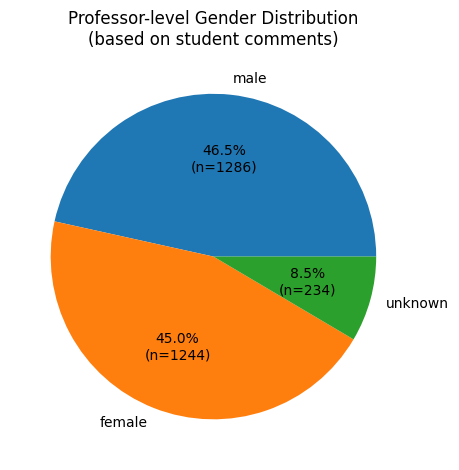

In [ ]:
# Visualization

import matplotlib.pyplot as plt


# Prepare professor-level counts
prof_gender_counts = (
    df_merged_2[["professor_name", "prof_gender_label_final"]]
    .drop_duplicates()
    ["prof_gender_label_final"]
    .value_counts(dropna=False)
)

# Plot: Pie chart of gender distribution
plt.figure()
plt.pie(
    prof_gender_counts.values,
    labels=prof_gender_counts.index,
    autopct=lambda p: f"{p:.1f}%\n(n={int(p/100 * prof_gender_counts.sum())})"
)
plt.title("Professor-level Gender Distribution\n(based on student comments)")
plt.tight_layout()
plt.show()



**Descriptive Analysis of Professor Gender Labels**

Using student comments, we labeled professors' gender based on pronouns such as "she" or "he". Out of the total labeled dataset, 1,244 professors (45.0%) were classified as female, 1,286 professors (46.5%) as male, and 234 professors (8.5%) remained unknown due to insufficient or ambiguous pronoun information.

The distribution indicates a roughly balanced representation of male and female professors in the dataset, with a small proportion of cases where gender could not be determined. The unknown group may reflect courses with few comments or where pronouns were not mentioned, highlighting the limitations of relying solely on textual cues for gender inference. This preliminary labeling provides a foundation for subsequent analyses comparing student evaluations and comment language across genders.